In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
class CNN(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super().__init__()
        
        
        self.features = nn.Sequential(
            nn.Conv2d(n_channels_in, 64, 3, 1, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, kernel_size=3, stride =1,padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, kernel_size=3, stride =1,padding = 1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size=3, stride =1,padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=3, stride =1,padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, n_channels_out, kernel_size=1,stride =1, padding = 0)
        )


    def forward(self, x):
        x = self.features(x)
        return x

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

In [6]:
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [7]:
train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    pickle_store(train_img_masks_save_path,train_img_masks)

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    pickle_store(val_img_masks_save_path,val_img_masks)

In [8]:
train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

In [9]:
net = CNN(4,5).to(device,dtype=torch.float32)
net.to(device) 
print(net)

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

CNN(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=

In [11]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_3'):
    os.mkdir('Model_3')
model_save_path = 'Model_3/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

[                                                                        ]N/A% 

Starting epoch 1/100.
0.0000 --- loss: 0.656477


[***************                                                         ] 21% 

0.2000 --- loss: 0.748271


[*****************************                                           ] 41% 

0.4000 --- loss: 0.682132


[********************************************                            ] 61% 

0.6000 --- loss: 0.617313


[**********************************************************              ] 81% 

0.8000 --- loss: 0.695900


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6579586863517761


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6331492066383362
Checkpoint 1 saved !
Starting epoch 2/100.
0.0000 --- loss: 0.628982


[***************                                                         ] 21% 

0.2000 --- loss: 0.652606


[*****************************                                           ] 41% 

0.4000 --- loss: 0.600060


[********************************************                            ] 61% 

0.6000 --- loss: 0.674145


[**********************************************************              ] 81% 

0.8000 --- loss: 0.692943


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6382245421409607


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6127766370773315
Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 0.573455


[***************                                                         ] 21% 

0.2000 --- loss: 0.660293


[*****************************                                           ] 41% 

0.4000 --- loss: 0.678479


[********************************************                            ] 61% 

0.6000 --- loss: 0.714312


[**********************************************************              ] 81% 

0.8000 --- loss: 0.712571


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6247243285179138


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6063515543937683
Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.629850


[***************                                                         ] 21% 

0.2000 --- loss: 0.539568


[*****************************                                           ] 41% 

0.4000 --- loss: 0.569835


[********************************************                            ] 61% 

0.6000 --- loss: 0.551072


[**********************************************************              ] 81% 

0.8000 --- loss: 0.573763


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6168838143348694


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5892961025238037
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.700993


[***************                                                         ] 21% 

0.2000 --- loss: 0.574275


[*****************************                                           ] 41% 

0.4000 --- loss: 0.578463


[********************************************                            ] 61% 

0.6000 --- loss: 0.618324


[**********************************************************              ] 81% 

0.8000 --- loss: 0.767143


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6070707440376282


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5926368236541748
Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.603836


[***************                                                         ] 21% 

0.2000 --- loss: 0.528942


[*****************************                                           ] 41% 

0.4000 --- loss: 0.555945


[********************************************                            ] 61% 

0.6000 --- loss: 0.611962


[**********************************************************              ] 81% 

0.8000 --- loss: 0.591934


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.6012892723083496


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5852420926094055
Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.544102


[***************                                                         ] 21% 

0.2000 --- loss: 0.552656


[*****************************                                           ] 41% 

0.4000 --- loss: 0.557519


[********************************************                            ] 61% 

0.6000 --- loss: 0.625866


[**********************************************************              ] 81% 

0.8000 --- loss: 0.658221


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5962989330291748


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5829386711120605
Checkpoint 7 saved !
Starting epoch 8/100.
0.0000 --- loss: 0.651262


[***************                                                         ] 21% 

0.2000 --- loss: 0.606107


[*****************************                                           ] 41% 

0.4000 --- loss: 0.565301


[********************************************                            ] 61% 

0.6000 --- loss: 0.552781


[**********************************************************              ] 81% 

0.8000 --- loss: 0.539788


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5909930467605591


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5892547369003296
Checkpoint 8 saved !
Starting epoch 9/100.
0.0000 --- loss: 0.583880


[***************                                                         ] 21% 

0.2000 --- loss: 0.582327


[*****************************                                           ] 41% 

0.4000 --- loss: 0.584007


[********************************************                            ] 61% 

0.6000 --- loss: 0.650451


[**********************************************************              ] 81% 

0.8000 --- loss: 0.654490


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5867578387260437


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.610419511795044
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.593601


[***************                                                         ] 21% 

0.2000 --- loss: 0.631894


[*****************************                                           ] 41% 

0.4000 --- loss: 0.572299


[********************************************                            ] 61% 

0.6000 --- loss: 0.586389


[**********************************************************              ] 81% 

0.8000 --- loss: 0.545331


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5865772366523743


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5639988780021667
Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.569252


[***************                                                         ] 21% 

0.2000 --- loss: 0.577703


[*****************************                                           ] 41% 

0.4000 --- loss: 0.555813


[********************************************                            ] 61% 

0.6000 --- loss: 0.568120


[**********************************************************              ] 81% 

0.8000 --- loss: 0.558120


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.576595664024353


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5606539845466614
Checkpoint 11 saved !
Starting epoch 12/100.
0.0000 --- loss: 0.592526


[***************                                                         ] 21% 

0.2000 --- loss: 0.575410


[*****************************                                           ] 41% 

0.4000 --- loss: 0.666362


[********************************************                            ] 61% 

0.6000 --- loss: 0.526378


[**********************************************************              ] 81% 

0.8000 --- loss: 0.575862


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5770809650421143


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5572004914283752
Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.686642


[***************                                                         ] 21% 

0.2000 --- loss: 0.567032


[*****************************                                           ] 41% 

0.4000 --- loss: 0.543297


[********************************************                            ] 61% 

0.6000 --- loss: 0.491840


[**********************************************************              ] 81% 

0.8000 --- loss: 0.623652


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.568717360496521


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.613264799118042
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.625512


[***************                                                         ] 21% 

0.2000 --- loss: 0.571600


[*****************************                                           ] 41% 

0.4000 --- loss: 0.537423


[********************************************                            ] 61% 

0.6000 --- loss: 0.639942


[**********************************************************              ] 81% 

0.8000 --- loss: 0.582715


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5695070624351501


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5632587671279907
Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.627622


[***************                                                         ] 21% 

0.2000 --- loss: 0.546360


[*****************************                                           ] 41% 

0.4000 --- loss: 0.538896


[********************************************                            ] 61% 

0.6000 --- loss: 0.466188


[**********************************************************              ] 81% 

0.8000 --- loss: 0.491190


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5665869116783142


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5854113101959229
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.507131


[***************                                                         ] 21% 

0.2000 --- loss: 0.566724


[*****************************                                           ] 41% 

0.4000 --- loss: 0.567850


[********************************************                            ] 61% 

0.6000 --- loss: 0.517048


[**********************************************************              ] 81% 

0.8000 --- loss: 0.563424


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.565860390663147


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5556619167327881
Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.734371


[***************                                                         ] 21% 

0.2000 --- loss: 0.573034


[*****************************                                           ] 41% 

0.4000 --- loss: 0.534197


[********************************************                            ] 61% 

0.6000 --- loss: 0.559176


[**********************************************************              ] 81% 

0.8000 --- loss: 0.484105


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.558205246925354


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.591946005821228
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.542977


[***************                                                         ] 21% 

0.2000 --- loss: 0.536333


[*****************************                                           ] 41% 

0.4000 --- loss: 0.606814


[********************************************                            ] 61% 

0.6000 --- loss: 0.570332


[**********************************************************              ] 81% 

0.8000 --- loss: 0.615731


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5581351518630981


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.571036696434021
Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.468743


[***************                                                         ] 21% 

0.2000 --- loss: 0.654048


[*****************************                                           ] 41% 

0.4000 --- loss: 0.553238


[********************************************                            ] 61% 

0.6000 --- loss: 0.596728


[**********************************************************              ] 81% 

0.8000 --- loss: 0.556171


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5559399724006653


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.548350989818573
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.563041


[***************                                                         ] 21% 

0.2000 --- loss: 0.520618


[*****************************                                           ] 41% 

0.4000 --- loss: 0.555184


[********************************************                            ] 61% 

0.6000 --- loss: 0.594678


[**********************************************************              ] 81% 

0.8000 --- loss: 0.544835


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5537140369415283


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5458500385284424
Checkpoint 20 saved !
Starting epoch 21/100.
0.0000 --- loss: 0.512578


[***************                                                         ] 21% 

0.2000 --- loss: 0.443806


[*****************************                                           ] 41% 

0.4000 --- loss: 0.453424


[********************************************                            ] 61% 

0.6000 --- loss: 0.551722


[**********************************************************              ] 81% 

0.8000 --- loss: 0.560312


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.548617959022522


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5436009168624878
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.515646


[***************                                                         ] 21% 

0.2000 --- loss: 0.550486


[*****************************                                           ] 41% 

0.4000 --- loss: 0.441874


[********************************************                            ] 61% 

0.6000 --- loss: 0.590742


[**********************************************************              ] 81% 

0.8000 --- loss: 0.499459


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5499285459518433


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.555949330329895
Checkpoint 22 saved !
Starting epoch 23/100.
0.0000 --- loss: 0.586761


[***************                                                         ] 21% 

0.2000 --- loss: 0.538120


[*****************************                                           ] 41% 

0.4000 --- loss: 0.559724


[********************************************                            ] 61% 

0.6000 --- loss: 0.557974


[**********************************************************              ] 81% 

0.8000 --- loss: 0.476912


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5463160872459412


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5353702306747437
Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.534995


[***************                                                         ] 21% 

0.2000 --- loss: 0.601985


[*****************************                                           ] 41% 

0.4000 --- loss: 0.553845


[********************************************                            ] 61% 

0.6000 --- loss: 0.495424


[**********************************************************              ] 81% 

0.8000 --- loss: 0.543816


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.542347252368927


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.548123836517334
Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.548821


[***************                                                         ] 21% 

0.2000 --- loss: 0.576474


[*****************************                                           ] 41% 

0.4000 --- loss: 0.541546


[********************************************                            ] 61% 

0.6000 --- loss: 0.527906


[**********************************************************              ] 81% 

0.8000 --- loss: 0.498149


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5422884225845337


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5382398962974548
Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.423451


[***************                                                         ] 21% 

0.2000 --- loss: 0.482618


[*****************************                                           ] 41% 

0.4000 --- loss: 0.514691


[********************************************                            ] 61% 

0.6000 --- loss: 0.512694


[**********************************************************              ] 81% 

0.8000 --- loss: 0.580659


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.542098343372345


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5439947843551636
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.503966


[***************                                                         ] 21% 

0.2000 --- loss: 0.522383


[*****************************                                           ] 41% 

0.4000 --- loss: 0.581409


[********************************************                            ] 61% 

0.6000 --- loss: 0.440511


[**********************************************************              ] 81% 

0.8000 --- loss: 0.449033


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5413772463798523


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5306885242462158
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.489847


[***************                                                         ] 21% 

0.2000 --- loss: 0.573698


[*****************************                                           ] 41% 

0.4000 --- loss: 0.573818


[********************************************                            ] 61% 

0.6000 --- loss: 0.564525


[**********************************************************              ] 81% 

0.8000 --- loss: 0.474032


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5399025678634644


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5365899205207825
Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.599963


[***************                                                         ] 21% 

0.2000 --- loss: 0.511927


[*****************************                                           ] 41% 

0.4000 --- loss: 0.516247


[********************************************                            ] 61% 

0.6000 --- loss: 0.559971


[**********************************************************              ] 81% 

0.8000 --- loss: 0.487416


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5359824895858765


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5277674198150635
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.427294


[***************                                                         ] 21% 

0.2000 --- loss: 0.572543


[*****************************                                           ] 41% 

0.4000 --- loss: 0.516010


[********************************************                            ] 61% 

0.6000 --- loss: 0.487376


[**********************************************************              ] 81% 

0.8000 --- loss: 0.513977


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5301377773284912


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5335106253623962
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.557262


[***************                                                         ] 21% 

0.2000 --- loss: 0.471678


[*****************************                                           ] 41% 

0.4000 --- loss: 0.526187


[********************************************                            ] 61% 

0.6000 --- loss: 0.564696


[**********************************************************              ] 81% 

0.8000 --- loss: 0.655275


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5348373651504517


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5537408590316772
Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.579731


[***************                                                         ] 21% 

0.2000 --- loss: 0.514459


[*****************************                                           ] 41% 

0.4000 --- loss: 0.511152


[********************************************                            ] 61% 

0.6000 --- loss: 0.571313


[**********************************************************              ] 81% 

0.8000 --- loss: 0.520643


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5327345132827759


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5333442687988281
Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.451589


[***************                                                         ] 21% 

0.2000 --- loss: 0.448141


[*****************************                                           ] 41% 

0.4000 --- loss: 0.529520


[********************************************                            ] 61% 

0.6000 --- loss: 0.489460


[**********************************************************              ] 81% 

0.8000 --- loss: 0.545231


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5290625095367432


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5280431509017944
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.572529


[***************                                                         ] 21% 

0.2000 --- loss: 0.516189


[*****************************                                           ] 41% 

0.4000 --- loss: 0.439204


[********************************************                            ] 61% 

0.6000 --- loss: 0.509683


[**********************************************************              ] 81% 

0.8000 --- loss: 0.539240


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5275346636772156


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5530340671539307
Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.480856


[***************                                                         ] 21% 

0.2000 --- loss: 0.478887


[*****************************                                           ] 41% 

0.4000 --- loss: 0.563604


[********************************************                            ] 61% 

0.6000 --- loss: 0.520481


[**********************************************************              ] 81% 

0.8000 --- loss: 0.458468


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5282522439956665


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5389423370361328
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.464044


[***************                                                         ] 21% 

0.2000 --- loss: 0.497435


[*****************************                                           ] 41% 

0.4000 --- loss: 0.487467


[********************************************                            ] 61% 

0.6000 --- loss: 0.531842


[**********************************************************              ] 81% 

0.8000 --- loss: 0.473336


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5285327434539795


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.550904393196106
Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.509894


[***************                                                         ] 21% 

0.2000 --- loss: 0.544343


[*****************************                                           ] 41% 

0.4000 --- loss: 0.526167


[********************************************                            ] 61% 

0.6000 --- loss: 0.460724


[**********************************************************              ] 81% 

0.8000 --- loss: 0.460755


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5302045345306396


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.568282425403595
Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.566050


[***************                                                         ] 21% 

0.2000 --- loss: 0.516036


[*****************************                                           ] 41% 

0.4000 --- loss: 0.528877


[********************************************                            ] 61% 

0.6000 --- loss: 0.553686


[**********************************************************              ] 81% 

0.8000 --- loss: 0.423217


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5310792922973633


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5403538942337036
Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.536904


[***************                                                         ] 21% 

0.2000 --- loss: 0.669991


[*****************************                                           ] 41% 

0.4000 --- loss: 0.463547


[********************************************                            ] 61% 

0.6000 --- loss: 0.583575


[**********************************************************              ] 81% 

0.8000 --- loss: 0.518884


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5282464623451233


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5301272869110107
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.598633


[***************                                                         ] 21% 

0.2000 --- loss: 0.585701


[*****************************                                           ] 41% 

0.4000 --- loss: 0.516789


[********************************************                            ] 61% 

0.6000 --- loss: 0.452193


[**********************************************************              ] 81% 

0.8000 --- loss: 0.473904


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5247846245765686


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5282226800918579
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.535096


[***************                                                         ] 21% 

0.2000 --- loss: 0.569533


[*****************************                                           ] 41% 

0.4000 --- loss: 0.483768


[********************************************                            ] 61% 

0.6000 --- loss: 0.408195


[**********************************************************              ] 81% 

0.8000 --- loss: 0.565057


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5219624042510986


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5263762474060059
Checkpoint 41 saved !
Starting epoch 42/100.
0.0000 --- loss: 0.632471


[***************                                                         ] 21% 

0.2000 --- loss: 0.520139


[*****************************                                           ] 41% 

0.4000 --- loss: 0.517815


[********************************************                            ] 61% 

0.6000 --- loss: 0.487180


[**********************************************************              ] 81% 

0.8000 --- loss: 0.436864


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5198209285736084


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.538356363773346
Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.534157


[***************                                                         ] 21% 

0.2000 --- loss: 0.537466


[*****************************                                           ] 41% 

0.4000 --- loss: 0.449977


[********************************************                            ] 61% 

0.6000 --- loss: 0.571793


[**********************************************************              ] 81% 

0.8000 --- loss: 0.445677


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5228282809257507


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.519408106803894
Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.550818


[***************                                                         ] 21% 

0.2000 --- loss: 0.437590


[*****************************                                           ] 41% 

0.4000 --- loss: 0.555591


[********************************************                            ] 61% 

0.6000 --- loss: 0.489008


[**********************************************************              ] 81% 

0.8000 --- loss: 0.546144


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5306993126869202


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5592512488365173
Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.631702


[***************                                                         ] 21% 

0.2000 --- loss: 0.482109


[*****************************                                           ] 41% 

0.4000 --- loss: 0.557764


[********************************************                            ] 61% 

0.6000 --- loss: 0.520342


[**********************************************************              ] 81% 

0.8000 --- loss: 0.493725


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5317898988723755


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5308791995048523
Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.508522


[***************                                                         ] 21% 

0.2000 --- loss: 0.493740


[*****************************                                           ] 41% 

0.4000 --- loss: 0.496415


[********************************************                            ] 61% 

0.6000 --- loss: 0.562652


[**********************************************************              ] 81% 

0.8000 --- loss: 0.602701


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5187062621116638


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5491658449172974
Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.451606


[***************                                                         ] 21% 

0.2000 --- loss: 0.633191


[*****************************                                           ] 41% 

0.4000 --- loss: 0.527432


[********************************************                            ] 61% 

0.6000 --- loss: 0.549594


[**********************************************************              ] 81% 

0.8000 --- loss: 0.408300


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.519646942615509


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.521316647529602
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.517186


[***************                                                         ] 21% 

0.2000 --- loss: 0.480322


[*****************************                                           ] 41% 

0.4000 --- loss: 0.565878


[********************************************                            ] 61% 

0.6000 --- loss: 0.506429


[**********************************************************              ] 81% 

0.8000 --- loss: 0.537291


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5112792253494263


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.532553493976593
Checkpoint 48 saved !
Starting epoch 49/100.
0.0000 --- loss: 0.462226


[***************                                                         ] 21% 

0.2000 --- loss: 0.448156


[*****************************                                           ] 41% 

0.4000 --- loss: 0.441500


[********************************************                            ] 61% 

0.6000 --- loss: 0.504068


[**********************************************************              ] 81% 

0.8000 --- loss: 0.600522


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5149216055870056


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.520663857460022
Checkpoint 49 saved !
Starting epoch 50/100.
0.0000 --- loss: 0.479152


[***************                                                         ] 21% 

0.2000 --- loss: 0.466617


[*****************************                                           ] 41% 

0.4000 --- loss: 0.574095


[********************************************                            ] 61% 

0.6000 --- loss: 0.507360


[**********************************************************              ] 81% 

0.8000 --- loss: 0.523660


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5108356475830078


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5219873189926147
Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.454460


[***************                                                         ] 21% 

0.2000 --- loss: 0.473028


[*****************************                                           ] 41% 

0.4000 --- loss: 0.492885


[********************************************                            ] 61% 

0.6000 --- loss: 0.433857


[**********************************************************              ] 81% 

0.8000 --- loss: 0.396327


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5126939415931702


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5184168219566345
Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.532298


[***************                                                         ] 21% 

0.2000 --- loss: 0.466008


[*****************************                                           ] 41% 

0.4000 --- loss: 0.544744


[********************************************                            ] 61% 

0.6000 --- loss: 0.501514


[**********************************************************              ] 81% 

0.8000 --- loss: 0.503626


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5112664699554443


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5257822275161743
Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.533078


[***************                                                         ] 21% 

0.2000 --- loss: 0.501431


[*****************************                                           ] 41% 

0.4000 --- loss: 0.489979


[********************************************                            ] 61% 

0.6000 --- loss: 0.440856


[**********************************************************              ] 81% 

0.8000 --- loss: 0.413189


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5106143951416016


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.519493579864502
Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.515981


[***************                                                         ] 21% 

0.2000 --- loss: 0.555167


[*****************************                                           ] 41% 

0.4000 --- loss: 0.433583


[********************************************                            ] 61% 

0.6000 --- loss: 0.507724


[**********************************************************              ] 81% 

0.8000 --- loss: 0.418749


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5160913467407227


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.545599639415741
Checkpoint 54 saved !
Starting epoch 55/100.
0.0000 --- loss: 0.420413


[***************                                                         ] 21% 

0.2000 --- loss: 0.482439


[*****************************                                           ] 41% 

0.4000 --- loss: 0.493533


[********************************************                            ] 61% 

0.6000 --- loss: 0.541406


[**********************************************************              ] 81% 

0.8000 --- loss: 0.633702


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5090330839157104


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5300225019454956
Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.462575


[***************                                                         ] 21% 

0.2000 --- loss: 0.549628


[*****************************                                           ] 41% 

0.4000 --- loss: 0.489493


[********************************************                            ] 61% 

0.6000 --- loss: 0.595497


[**********************************************************              ] 81% 

0.8000 --- loss: 0.584282


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.506371021270752


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5270969867706299
Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.458610


[***************                                                         ] 21% 

0.2000 --- loss: 0.572763


[*****************************                                           ] 41% 

0.4000 --- loss: 0.498495


[********************************************                            ] 61% 

0.6000 --- loss: 0.486338


[**********************************************************              ] 81% 

0.8000 --- loss: 0.481522


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5071378350257874


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5300968885421753
Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.484891


[***************                                                         ] 21% 

0.2000 --- loss: 0.459375


[*****************************                                           ] 41% 

0.4000 --- loss: 0.624933


[********************************************                            ] 61% 

0.6000 --- loss: 0.512085


[**********************************************************              ] 81% 

0.8000 --- loss: 0.568470


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5091848373413086


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5272634029388428
Checkpoint 58 saved !
Starting epoch 59/100.
0.0000 --- loss: 0.535902


[***************                                                         ] 21% 

0.2000 --- loss: 0.509885


[*****************************                                           ] 41% 

0.4000 --- loss: 0.467304


[********************************************                            ] 61% 

0.6000 --- loss: 0.496036


[**********************************************************              ] 81% 

0.8000 --- loss: 0.550546


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5028369426727295


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5229164958000183
Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.527599


[***************                                                         ] 21% 

0.2000 --- loss: 0.479170


[*****************************                                           ] 41% 

0.4000 --- loss: 0.456712


[********************************************                            ] 61% 

0.6000 --- loss: 0.481415


[**********************************************************              ] 81% 

0.8000 --- loss: 0.543749


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.5033054351806641


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5175255537033081
Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.483758


[***************                                                         ] 21% 

0.2000 --- loss: 0.435050


[*****************************                                           ] 41% 

0.4000 --- loss: 0.496236


[********************************************                            ] 61% 

0.6000 --- loss: 0.479485


[**********************************************************              ] 81% 

0.8000 --- loss: 0.563129


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5028674602508545


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5178408622741699
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.452248


[***************                                                         ] 21% 

0.2000 --- loss: 0.451809


[*****************************                                           ] 41% 

0.4000 --- loss: 0.549508


[********************************************                            ] 61% 

0.6000 --- loss: 0.527514


[**********************************************************              ] 81% 

0.8000 --- loss: 0.509067


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5007671117782593


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5329934358596802
Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.525253


[***************                                                         ] 21% 

0.2000 --- loss: 0.497009


[*****************************                                           ] 41% 

0.4000 --- loss: 0.526849


[********************************************                            ] 61% 

0.6000 --- loss: 0.502004


[**********************************************************              ] 81% 

0.8000 --- loss: 0.620464


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5019636154174805


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5990225076675415
Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.545837


[***************                                                         ] 21% 

0.2000 --- loss: 0.469316


[*****************************                                           ] 41% 

0.4000 --- loss: 0.488820


[********************************************                            ] 61% 

0.6000 --- loss: 0.492022


[**********************************************************              ] 81% 

0.8000 --- loss: 0.535243


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.49757859110832214


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5080358386039734
Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.491391


[***************                                                         ] 21% 

0.2000 --- loss: 0.445411


[*****************************                                           ] 41% 

0.4000 --- loss: 0.521963


[********************************************                            ] 61% 

0.6000 --- loss: 0.456705


[**********************************************************              ] 81% 

0.8000 --- loss: 0.463263


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5005467534065247


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5157269239425659
Checkpoint 65 saved !
Starting epoch 66/100.
0.0000 --- loss: 0.417071


[***************                                                         ] 21% 

0.2000 --- loss: 0.466689


[*****************************                                           ] 41% 

0.4000 --- loss: 0.569568


[********************************************                            ] 61% 

0.6000 --- loss: 0.470783


[**********************************************************              ] 81% 

0.8000 --- loss: 0.485844


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.5002732872962952


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5142984986305237
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.595850


[***************                                                         ] 21% 

0.2000 --- loss: 0.408004


[*****************************                                           ] 41% 

0.4000 --- loss: 0.509049


[********************************************                            ] 61% 

0.6000 --- loss: 0.528679


[**********************************************************              ] 81% 

0.8000 --- loss: 0.432620


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4969836175441742


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5120999813079834
Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.482884


[***************                                                         ] 21% 

0.2000 --- loss: 0.428236


[*****************************                                           ] 41% 

0.4000 --- loss: 0.511845


[********************************************                            ] 61% 

0.6000 --- loss: 0.518032


[**********************************************************              ] 81% 

0.8000 --- loss: 0.579474


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.49707990884780884


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5103669166564941
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.377039


[***************                                                         ] 21% 

0.2000 --- loss: 0.502613


[*****************************                                           ] 41% 

0.4000 --- loss: 0.574013


[********************************************                            ] 61% 

0.6000 --- loss: 0.494049


[**********************************************************              ] 81% 

0.8000 --- loss: 0.533348


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.49384501576423645


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5286539793014526
Checkpoint 69 saved !
Starting epoch 70/100.
0.0000 --- loss: 0.420132


[***************                                                         ] 21% 

0.2000 --- loss: 0.541093


[*****************************                                           ] 41% 

0.4000 --- loss: 0.439924


[********************************************                            ] 61% 

0.6000 --- loss: 0.447972


[**********************************************************              ] 81% 

0.8000 --- loss: 0.497824


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.49436014890670776


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5155924558639526
Checkpoint 70 saved !
Starting epoch 71/100.
0.0000 --- loss: 0.518624


[***************                                                         ] 21% 

0.2000 --- loss: 0.490220


[*****************************                                           ] 41% 

0.4000 --- loss: 0.456498


[********************************************                            ] 61% 

0.6000 --- loss: 0.522452


[**********************************************************              ] 81% 

0.8000 --- loss: 0.484451


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.49558907747268677


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5136663317680359
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.468028


[***************                                                         ] 21% 

0.2000 --- loss: 0.450481


[*****************************                                           ] 41% 

0.4000 --- loss: 0.474395


[********************************************                            ] 61% 

0.6000 --- loss: 0.440042


[**********************************************************              ] 81% 

0.8000 --- loss: 0.430955


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4919615387916565


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5587273836135864
Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.520519


[***************                                                         ] 21% 

0.2000 --- loss: 0.528892


[*****************************                                           ] 41% 

0.4000 --- loss: 0.475803


[********************************************                            ] 61% 

0.6000 --- loss: 0.514837


[**********************************************************              ] 81% 

0.8000 --- loss: 0.487077


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.49484407901763916


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5123772025108337
Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.505713


[***************                                                         ] 21% 

0.2000 --- loss: 0.516378


[*****************************                                           ] 41% 

0.4000 --- loss: 0.461290


[********************************************                            ] 61% 

0.6000 --- loss: 0.583455


[**********************************************************              ] 81% 

0.8000 --- loss: 0.501537


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.49186602234840393


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5222305655479431
Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.552596


[***************                                                         ] 21% 

0.2000 --- loss: 0.555116


[*****************************                                           ] 41% 

0.4000 --- loss: 0.504825


[********************************************                            ] 61% 

0.6000 --- loss: 0.468631


[**********************************************************              ] 81% 

0.8000 --- loss: 0.467828


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.49115756154060364


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5283570289611816
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.429082


[***************                                                         ] 21% 

0.2000 --- loss: 0.418415


[*****************************                                           ] 41% 

0.4000 --- loss: 0.414576


[********************************************                            ] 61% 

0.6000 --- loss: 0.451266


[**********************************************************              ] 81% 

0.8000 --- loss: 0.588517


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.49272578954696655


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5057018995285034
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.507233


[***************                                                         ] 21% 

0.2000 --- loss: 0.482654


[*****************************                                           ] 41% 

0.4000 --- loss: 0.533560


[********************************************                            ] 61% 

0.6000 --- loss: 0.491901


[**********************************************************              ] 81% 

0.8000 --- loss: 0.441143


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.48825839161872864


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5258911848068237
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.545333


[***************                                                         ] 21% 

0.2000 --- loss: 0.455555


[*****************************                                           ] 41% 

0.4000 --- loss: 0.446180


[********************************************                            ] 61% 

0.6000 --- loss: 0.545693


[**********************************************************              ] 81% 

0.8000 --- loss: 0.503675


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4921325445175171


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5181124210357666
Checkpoint 78 saved !
Starting epoch 79/100.
0.0000 --- loss: 0.509026


[***************                                                         ] 21% 

0.2000 --- loss: 0.426090


[*****************************                                           ] 41% 

0.4000 --- loss: 0.496700


[********************************************                            ] 61% 

0.6000 --- loss: 0.467178


[**********************************************************              ] 81% 

0.8000 --- loss: 0.479963


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4897894859313965


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5062053799629211
Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.576175


[***************                                                         ] 21% 

0.2000 --- loss: 0.467003


[*****************************                                           ] 41% 

0.4000 --- loss: 0.447956


[********************************************                            ] 61% 

0.6000 --- loss: 0.463998


[**********************************************************              ] 81% 

0.8000 --- loss: 0.507653


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4838320016860962


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5203492641448975
Checkpoint 80 saved !
Starting epoch 81/100.
0.0000 --- loss: 0.498922


[***************                                                         ] 21% 

0.2000 --- loss: 0.370405


[*****************************                                           ] 41% 

0.4000 --- loss: 0.522253


[********************************************                            ] 61% 

0.6000 --- loss: 0.441064


[**********************************************************              ] 81% 

0.8000 --- loss: 0.526391


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4849686026573181


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5148666501045227
Checkpoint 81 saved !
Starting epoch 82/100.
0.0000 --- loss: 0.387610


[***************                                                         ] 21% 

0.2000 --- loss: 0.530625


[*****************************                                           ] 41% 

0.4000 --- loss: 0.542097


[********************************************                            ] 61% 

0.6000 --- loss: 0.472168


[**********************************************************              ] 81% 

0.8000 --- loss: 0.479008


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4844188988208771


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.509040117263794
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.441194


[***************                                                         ] 21% 

0.2000 --- loss: 0.394468


[*****************************                                           ] 41% 

0.4000 --- loss: 0.397078


[********************************************                            ] 61% 

0.6000 --- loss: 0.484980


[**********************************************************              ] 81% 

0.8000 --- loss: 0.499261


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.48394352197647095


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5159529447555542
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.479085


[***************                                                         ] 21% 

0.2000 --- loss: 0.580522


[*****************************                                           ] 41% 

0.4000 --- loss: 0.375425


[********************************************                            ] 61% 

0.6000 --- loss: 0.511909


[**********************************************************              ] 81% 

0.8000 --- loss: 0.495555


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.48366862535476685


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5040280222892761
Checkpoint 84 saved !
Starting epoch 85/100.
0.0000 --- loss: 0.384178


[***************                                                         ] 21% 

0.2000 --- loss: 0.514289


[*****************************                                           ] 41% 

0.4000 --- loss: 0.517223


[********************************************                            ] 61% 

0.6000 --- loss: 0.513739


[**********************************************************              ] 81% 

0.8000 --- loss: 0.413756


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.4840022623538971


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5083606243133545
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.486383


[***************                                                         ] 21% 

0.2000 --- loss: 0.424288


[*****************************                                           ] 41% 

0.4000 --- loss: 0.501362


[********************************************                            ] 61% 

0.6000 --- loss: 0.494603


[**********************************************************              ] 81% 

0.8000 --- loss: 0.504357


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4828752875328064


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5069001913070679
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.507697


[***************                                                         ] 21% 

0.2000 --- loss: 0.455756


[*****************************                                           ] 41% 

0.4000 --- loss: 0.475069


[********************************************                            ] 61% 

0.6000 --- loss: 0.444672


[**********************************************************              ] 81% 

0.8000 --- loss: 0.433931


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4819525480270386


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5083675384521484
Checkpoint 87 saved !
Starting epoch 88/100.
0.0000 --- loss: 0.514568


[***************                                                         ] 21% 

0.2000 --- loss: 0.488160


[*****************************                                           ] 41% 

0.4000 --- loss: 0.518316


[********************************************                            ] 61% 

0.6000 --- loss: 0.437790


[**********************************************************              ] 81% 

0.8000 --- loss: 0.498789


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4823828935623169


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5206801891326904
Checkpoint 88 saved !
Starting epoch 89/100.
0.0000 --- loss: 0.465636


[***************                                                         ] 21% 

0.2000 --- loss: 0.408944


[*****************************                                           ] 41% 

0.4000 --- loss: 0.426383


[********************************************                            ] 61% 

0.6000 --- loss: 0.548892


[**********************************************************              ] 81% 

0.8000 --- loss: 0.549787


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4809049665927887


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5126121044158936
Checkpoint 89 saved !
Starting epoch 90/100.
0.0000 --- loss: 0.528899


[***************                                                         ] 21% 

0.2000 --- loss: 0.397195


[*****************************                                           ] 41% 

0.4000 --- loss: 0.510868


[********************************************                            ] 61% 

0.6000 --- loss: 0.402176


[**********************************************************              ] 81% 

0.8000 --- loss: 0.490830


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47905221581459045


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5167572498321533
Checkpoint 90 saved !
Starting epoch 91/100.
0.0000 --- loss: 0.485950


[***************                                                         ] 21% 

0.2000 --- loss: 0.415303


[*****************************                                           ] 41% 

0.4000 --- loss: 0.451665


[********************************************                            ] 61% 

0.6000 --- loss: 0.530563


[**********************************************************              ] 81% 

0.8000 --- loss: 0.448091


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47887420654296875


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5094318389892578
Checkpoint 91 saved !
Starting epoch 92/100.
0.0000 --- loss: 0.481049


[***************                                                         ] 21% 

0.2000 --- loss: 0.532667


[*****************************                                           ] 41% 

0.4000 --- loss: 0.506350


[********************************************                            ] 61% 

0.6000 --- loss: 0.447334


[**********************************************************              ] 81% 

0.8000 --- loss: 0.420432


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47842293977737427


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5088269114494324
Checkpoint 92 saved !
Starting epoch 93/100.
0.0000 --- loss: 0.503589


[***************                                                         ] 21% 

0.2000 --- loss: 0.489098


[*****************************                                           ] 41% 

0.4000 --- loss: 0.507834


[********************************************                            ] 61% 

0.6000 --- loss: 0.501891


[**********************************************************              ] 81% 

0.8000 --- loss: 0.480544


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4769437909126282


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5042139291763306
Checkpoint 93 saved !
Starting epoch 94/100.
0.0000 --- loss: 0.492092


[***************                                                         ] 21% 

0.2000 --- loss: 0.540447


[*****************************                                           ] 41% 

0.4000 --- loss: 0.586712


[********************************************                            ] 61% 

0.6000 --- loss: 0.477889


[**********************************************************              ] 81% 

0.8000 --- loss: 0.480308


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.4798778295516968


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.510955274105072
Checkpoint 94 saved !
Starting epoch 95/100.
0.0000 --- loss: 0.466663


[***************                                                         ] 21% 

0.2000 --- loss: 0.414101


[*****************************                                           ] 41% 

0.4000 --- loss: 0.488162


[********************************************                            ] 61% 

0.6000 --- loss: 0.520784


[**********************************************************              ] 81% 

0.8000 --- loss: 0.424947


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.47948747873306274


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5062769651412964
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.459473


[***************                                                         ] 21% 

0.2000 --- loss: 0.424586


[*****************************                                           ] 41% 

0.4000 --- loss: 0.438277


[********************************************                            ] 61% 

0.6000 --- loss: 0.481166


[**********************************************************              ] 81% 

0.8000 --- loss: 0.641506


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.48028868436813354


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5051081776618958
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.473374


[***************                                                         ] 21% 

0.2000 --- loss: 0.487772


[*****************************                                           ] 41% 

0.4000 --- loss: 0.485876


[********************************************                            ] 61% 

0.6000 --- loss: 0.374858


[**********************************************************              ] 81% 

0.8000 --- loss: 0.436569


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47695624828338623


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5096583366394043
Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.541634


[***************                                                         ] 21% 

0.2000 --- loss: 0.509099


[*****************************                                           ] 41% 

0.4000 --- loss: 0.440829


[********************************************                            ] 61% 

0.6000 --- loss: 0.427913


[**********************************************************              ] 81% 

0.8000 --- loss: 0.521047


[******                                                                  ]  8% 

Epoch finished ! Loss: 0.47665178775787354


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5065840482711792
Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.487052


[***************                                                         ] 21% 

0.2000 --- loss: 0.465814


[*****************************                                           ] 41% 

0.4000 --- loss: 0.479761


[********************************************                            ] 61% 

0.6000 --- loss: 0.416383


[**********************************************************              ] 81% 

0.8000 --- loss: 0.494436


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47425776720046997


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5173497200012207
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.499044


[***************                                                         ] 21% 

0.2000 --- loss: 0.388473


[*****************************                                           ] 41% 

0.4000 --- loss: 0.512221


[********************************************                            ] 61% 

0.6000 --- loss: 0.502879


[**********************************************************              ] 81% 

0.8000 --- loss: 0.466217


[*********                                                               ] 12% 

Epoch finished ! Loss: 0.47302600741386414


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.519171953201294
Checkpoint 100 saved !


In [12]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)


def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [13]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  
            #green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264
(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


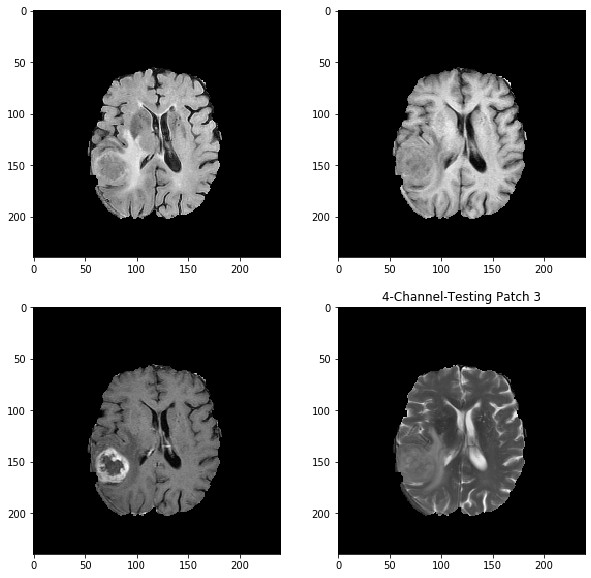

In [29]:
test_segmentation(3)

43264
(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264
(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264
(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


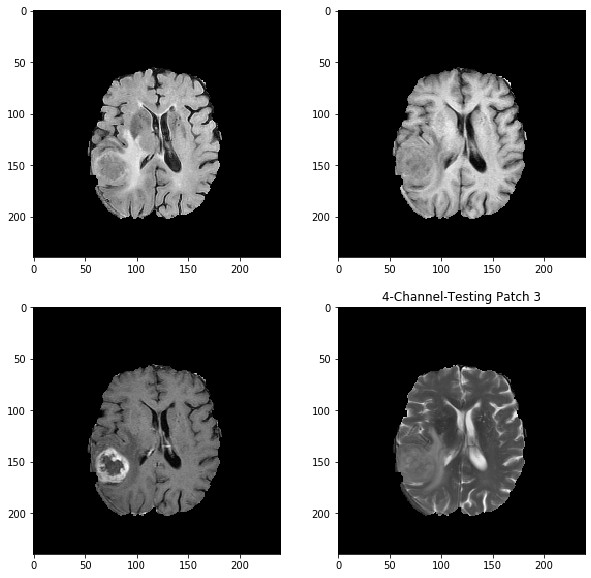

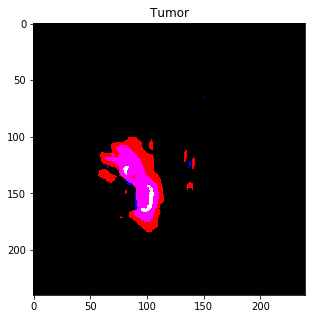

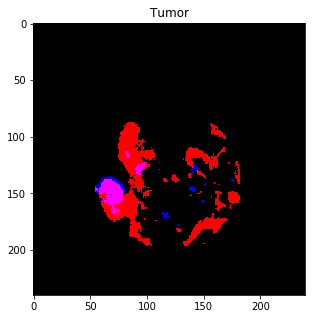

In [30]:
test_cases=[3,14,28]
for i in range(len(test_cases)):
    test_segmentation(test_cases[i])